### Imports

In [1]:
import torch
import torch_geometric
import torch.nn as nn
import explainer
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import torch.nn.functional as fn
from torch_geometric.utils import k_hop_subgraph
import utils

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(explainer)
importlib.reload(utils)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [4]:
batch_size = 64
sampled_graphs = 20

learning_rate_mlp = 0.01            #Paper: 0.003, code 0.01, codePyG 0.0003
coefficientSizeReg = 0.01           #Paper: 0.05, code 0.01, codePyG 0.005
entropyReg = 0.01                   #Paper: 1, code 0.01, codePyG 1
epochs_mlp = 20                     #Paper: 30 for all datasets => code uses 10

# Temperature
t_0 =  5.0
t_T = 5.0                           #Paper says 2.0, Code say 5.0, uses 1.0 , codePyG 5.0 =>

datasetName: Literal['BA2Motif','MUTAG'] = 'MUTAG'
MUTAG = True        
# MUTAG DATASET SHAPE
# edge_attr: "valence" [edges, 3], contains bond type: Single, double triple
# x: "chem" [nodes, 14], node features:
# 0  1  2  3  4  5  6  7  8  9  10  11  12  13
# C  O  C1 H  N  F  Br S  P  I  Na  K   Li  Ca
# y: graph label, 0 mutagenic 1 nonmutagenic            MUTAGENIC: N(blue) H2(green), N(blue) O2(red)
# TODO: Original uses adapted dataset that contains Mutagenicity_edge_gt! => To only get graphs that are mutagenic and contain NO2 and NH2 motifs

### Load and visualize data

Data(edge_index=[2, 78], x=[36, 14], edge_attr=[78, 3], y=[1])
tensor([0])
tensor([0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


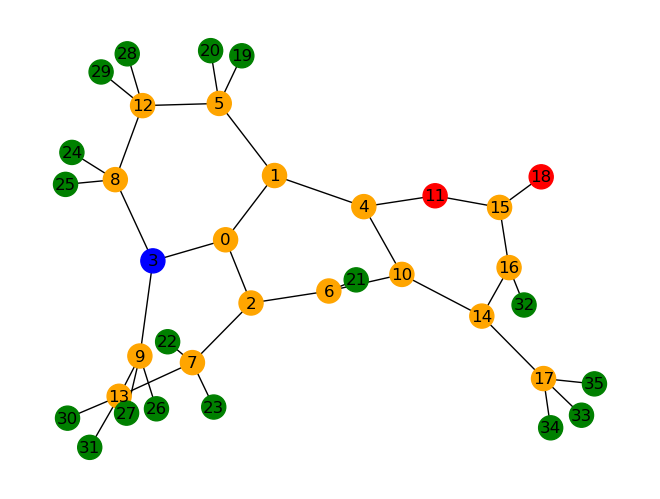

In [5]:
# TODO: MUTAG NEEDS TO BE PREPROCESSED: Extract all mutagenic NO2 and NH2 graphs, train and eval on only those!
# TODO: EXTRACT GROUND TRUTHS?? => Edge labels = edge_gt


train_dataset, val_dataset, test_dataset = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)

print(train_dataset[0])
print(train_dataset[0].y)
print(torch.argmax(train_dataset[0].x, dim=1))

graph = Data(train_dataset[0].x, train_dataset[0].edge_index)

utils.plotGraph(graph, MUTAG=MUTAG)

train_loader = DataLoader(train_dataset, batch_size, False)             # TODO: Data not shuffled to match calculated embeddings to correct graphs! Should work now, as embeddings are calculated on the fly per batch
val_loader = DataLoader(val_dataset, batch_size, False)
test_loader = DataLoader(test_dataset, batch_size)

### Load GNN model

In [6]:
modelGraphGNN = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)     # Adjust according to data and task
modelGraphGNN.load_state_dict(torch.load("models/MUTAG 86 highest val", weights_only=True))

<All keys matched successfully>

### Training Loop Graph Classification Explainer

In [8]:
#torch.set_printoptions(threshold=10_000)

# TODO: IN og this only trains on mutagenic data?!?!?!?! Plus evaluate only on mutagenic!

mlp = explainer.MLP()

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp, maximize=False)

modelGraphGNN.eval()
for param in modelGraphGNN.parameters():
    param.requires_grad = False

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

    Loss = torch.FloatTensor([0])

    for batch_index, data in enumerate(train_loader):
        # MLP forward                                                           # shape embeddings[batch_index]: ~50 X 40 = Edges X hidden_embs_2Nodes
        w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)               # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        sampleLoss = Loss = torch.FloatTensor([0])
        
        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here. Probably correct here, can also be found in og Explainer.call
            # TODO: Validate correct prediction on batches!!!
            pOriginal = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch), dim=1)
            pSample = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch, edge_weights=edge_ij), dim=1)

            # TODO: Validate loss function, True_one_hot labels needed??
            # TODO: Implement correct loss for each graph per batch => Should be good
            for graph_index in range(data.num_graphs):
                node_mask = data.batch == graph_index
                edge_mask = (node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]])

                # TODO: VALIDATE pOriginal and pSample pass both label predictions, not just correct one
                currLoss = mlp.loss(pOriginal[graph_index], pSample[graph_index], edge_ij[edge_mask], coefficientSizeReg, entropyReg)
                #lossEntropy = fn.cross_entropy(fn.softmax(pOriginal,dim=1), fn.softmax(pSample, dim=1))
                sampleLoss += currLoss
                #Loss += currLoss
        
        Loss += sampleLoss / sampled_graphs
        
    Loss.backward()
    
    #Loss = Loss / len(train_loader.dataset) / sampled_graphs           # TODO: Validate, apply batchsizeratio 

    print(f"Epoch {epoch+1}, Loss: {Loss.item()}")

    #torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=2)

    mlp_optimizer.step()

    mlp.eval()
    
    evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, val_dataset, MUTAG)
    #out = mlp.forward(modelGraphGNN, val_dataset[0].x, val_dataset[0].edge_index)

    #print(f"MLP Output for first val graph in epoch {epoch+1}:")
    #print(out.squeeze(1))

    """for name, param in mlp.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.grad}")"""

Epoch 1, Loss: 381.9317932128906


c:\Users\trist\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


AUC of ROC: 0.6169230937957764
BinaryAUROC: 0.6727922068492715
roc_auc_score: 0.5711538461538462
Epoch 2, Loss: 381.3686218261719


c:\Users\trist\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


AUC of ROC: 0.6608163118362427
BinaryAUROC: 0.6697151358486765
roc_auc_score: 0.5596153846153846
Epoch 3, Loss: 374.1450500488281


c:\Users\trist\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


AUC of ROC: 0.6659765839576721
BinaryAUROC: 0.6312644927215556
roc_auc_score: 0.5326923076923078
Epoch 4, Loss: 372.36248779296875


c:\Users\trist\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


AUC of ROC: 0.6472277641296387
BinaryAUROC: 0.6031911276967176
roc_auc_score: 0.5250000000000001
Epoch 5, Loss: 369.75701904296875


c:\Users\trist\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


AUC of ROC: 0.6452719569206238
BinaryAUROC: 0.5941300217599877
roc_auc_score: 0.5365384615384616


KeyboardInterrupt: 

In [16]:
torch.save(mlp.state_dict(), f"models/compare/explainerMUTAG_005size01ent_tT1_lowLR_AUC67_LEARNS_HIGHEST")

#### Calculate AUC between explanation edge probabilites and ground truth edges

0.47731736302375793


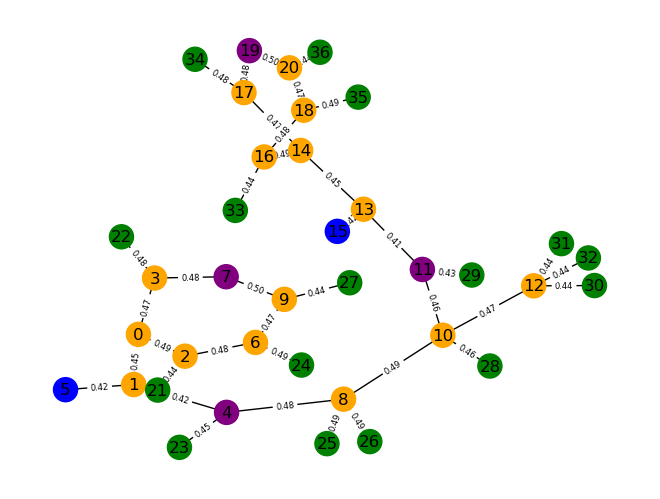

In [21]:
import evaluation
importlib.reload(evaluation)
# TODO: Work on different batch sizes

# TODO: Not working? Flips edge weights
data = evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, test_dataset, MUTAG)
w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)
edge_ij = mlp.sampleGraph(w_ij, temperature)

Graph = Data(x=data.x,edge_index=data.edge_index,edge_attr=edge_ij.detach())
pos1 = utils.plotGraph(Graph, pos=None, color_map=None, edge_weights=True, MUTAG=MUTAG)